# Data description and preprocessing



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Pandas version:  1.4.2
Numpy version:  1.21.5
Scikit-learn version:  1.0.2


# 1. Analyzing training data

## 1.1. Training Input 

In [2]:
dataset_path = "C:\\Users\\d616780\\DQuan\\2022\\12-Projet_fil_rouge\\CMAPPS_data"

In [3]:
train_data = pd.read_csv(dataset_path + "\\train_FD001.txt", sep = "\s+", header = None)
train_data.shape

(20631, 26)

In [4]:
train_data[0:193]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,21.61,550.70,2388.27,9044.55,1.3,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,21.61,551.25,2388.32,9033.22,1.3,48.25,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649


This dataset has 26 columns. Description of each column is as follows:

* `Column 0`: Corresponds to engine number (This column is indexed 0 above because of Python's numbering convention)
* `Column 1`: Corresponds to cycle number. If engine 1 fails after 192 cycles, the entries of second column for engine 1 will go from 1 to 192. Similarly for other engines. 
* `Columns 2,3,4`: 3 operational settings
* `Columns 5-25`: 21 sensor measurements



In [5]:
num_cycles_to_failure = train_data.groupby(0)[1].count()
print(num_cycles_to_failure)

0
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: 1, Length: 100, dtype: int64


## 1.2. Defining degradation model => Outputs of training set

RUL of the engines is not explicitly given in the traning data; however, we can calculate RUL values from the training data. Remember that training data contains run to failure data of all engines.

- `Linear degradation model`: Engine 1 fails after 192 cycles. So at the first cycle of engine 1, its RUL is 191. After cycle 2, its RUL is 190 and so on. As it fails after 192 cycles, at 192nd cycle, its RUL is 0. This type of degradation model is called linear degradation model. From the start of the cycle it decreases gradually to 0 at the last cycle.

- `Piecewise linear degradation model`: at the beginning (for a number of cycles), RUL is assigned to a fixed number. The fixed number is called early RUL. When RUL value reaches early RUL, from there on RUL follows a linear degradation model.

To illustrate both degradation model, we will plot RUL values for engine 1 using both models. RUL of engine 1 is 192 (found above). For piecewise linear degradation model, we take early RUL to be 125 (It's just a choice. There is no definite rule for selecting this value).

In [7]:
engine_1_linear_degradation_model = np.arange(192 -1, -1, -1)   # step down from 191 to 0 with a step -1 each time

# Piecewise_linear_degradation model
early_rul = 125
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape = (192-early_rul,)),
                                                        np.arange(early_rul-1, -1, -1))

In [81]:
'''
One might choose a degradation model of the form:
rul(t) = max_rul - np.exp(a*t +b)
such that rul(191) = 0 
'''
max_rul = 192
exponential_degradation = []
for t in range(192):
    rul = np.round(max_rul - np.exp(t*np.log(max_rul)/191),4   )
    exponential_degradation.append(rul)
exponential_degradation = np.array(exponential_degradation)

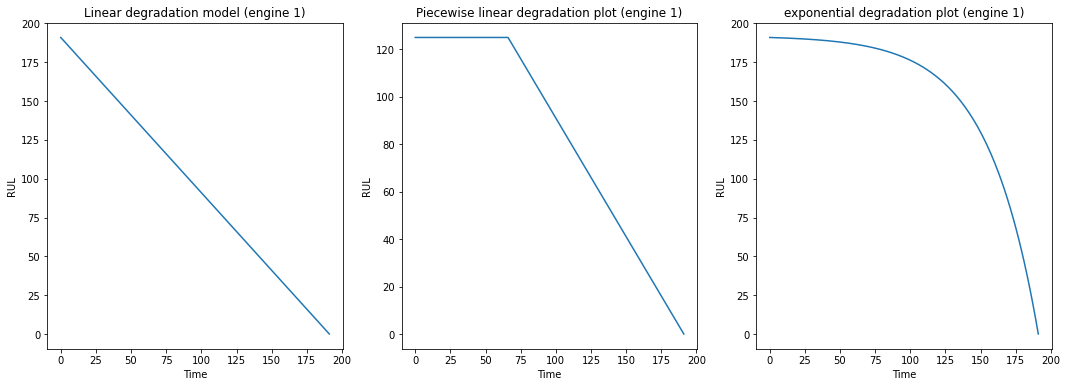

In [82]:
fig, ax = plt.subplots(1,3,figsize = (18, 6))

ax[0].plot(engine_1_linear_degradation_model)
ax[0].set_title("Linear degradation model (engine 1)")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('RUL')


ax[1].plot(engine_1_piecewise_linear_degradation_model)
ax[1].set_title("Piecewise linear degradation plot (engine 1)")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RUL')


ax[2].plot(exponential_degradation)
ax[2].set_title("exponential degradation plot (engine 1)")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('RUL')

plt.show()

In the following, we will focus on the piecewise linear degradation. 

### Exercise 1: 

**Ex1: Write a function that determine the RUL in a linear and piecewise_linear model (with early_rul as a parameter)**

In [ ]:
def RUL_piecelinear(data_length, early_rul = None):
    """    
    Arguments:
        data_length: (scaler) Number of cycles for each engine
        early_rul: (scaler) Early RUL value to be set. When set to `None`, linear degradation
                   curve is used. (deafult: None)

    Returns:
        target_array: (1D float array) Target array
    """
    

Ex2: Examples: Plot out the RUL of an engine

In [ ]:
'''
Plot out to check RUL
'''

**Ex3: Create the output data for all 100 engines in traning dataset 1:**
Create and save the RUL of engine i under the piecewise linear degradation model with ```early_rul = 125```

In [73]:
'''
for i in range(number of engines):
    Derive the RUL of engine i according to the piecewise linear model

Save all these to a file called 'dataset_path + '\\RUL_train\\RUL_train_FD001_early=125.txt'
'''
early_rul = 125
num_of_engines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])
RUL_list = np.array([])
engines = np.array([])
for i in range(num_of_engines):
    number_of_cycles_i = int(np.array(num_cycles_to_failure)[i])       # This is 192 for the first engine, 287 for the 2nd engine, etc
    engine_i_model = np.append(early_rul*np.ones(shape = (number_of_cycles_i-early_rul,)),np.arange(early_rul-1, -1, -1))
    RUL_list = np.concatenate((RUL_list, engine_i_model), axis = 0)
    engines = np.concatenate((engines, (i+1) * np.ones(number_of_cycles_i) ), axis = 0)
    

df = pd.DataFrame({'engines': engines, 'RUL': RUL_list })
'''
We save the RUL of the piecewise linear degrdation model of engine 1
'''
import os
if not os.path.exists(dataset_path + '\\RUL_train'): os.makedirs(dataset_path + '\\RUL_train')    
df.to_csv(dataset_path + '\\RUL_train\\RUL_train_FD001_early=125.csv', index = False)

**Ex4: Create the output data for all 100 engines in traning dataset 1:**
Create and save the RUL of engine i under the exponential degradation model


In [85]:
'''
for i in range(number of engines):
    Derive the RUL of engine i according to the piecewise linear model

Save all these to a file called 'dataset_path + '\\RUL_train\\RUL_train_FD001_early=125.txt'
'''
max_rul = 125
exponential_degradation = []



num_of_engines = len(train_data[0].unique())
RUL_list = np.array([])
engines = np.array([])
for i in range(num_of_engines):
    number_of_cycles_i = int(np.array(num_cycles_to_failure)[i])       # This is 192 for the first engine, 287 for the 2nd engine, etc
    engine_i_model=[]
    for t in range(number_of_cycles_i):
        rul = np.round(max_rul - np.exp(t*np.log(max_rul)/ (number_of_cycles_i-1)),4   )
        engine_i_model.append(rul)
    engine_i_model = np.array(engine_i_model)
    RUL_list = np.concatenate((RUL_list, engine_i_model), axis = 0)
    engines = np.concatenate((engines, (i+1) * np.ones(number_of_cycles_i) ), axis = 0)
    

df = pd.DataFrame({'engines': engines, 'RUL': RUL_list })
'''
We save the RUL of the piecewise linear degrdation model of engine 1
'''
import os
if not os.path.exists(dataset_path + '\\RUL_train'): os.makedirs(dataset_path + '\\RUL_train')    
df.to_csv(dataset_path + '\\RUL_train\\RUL_train_FD001_exp_max=125.csv', index = False)

## 2. Analyzing Test data

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

## 2.1. Test Input

In [24]:
test_data = pd.read_csv(dataset_path + "\\test_FD001.txt", sep = "\s+", header = None)
test_data.shape

(13096, 26)

In [78]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [26]:
test_data.groupby(0)[1].count()

0
1       31
2       49
3      126
4      106
5       98
      ... 
96      97
97     134
98     121
99      97
100    198
Name: 1, Length: 100, dtype: int64

## 2.2. Test output (true values)

In [59]:
rul_of_last = pd.read_csv(dataset_path + "\\RUL_FD001.txt", sep = '\s+', header = None)
rul_of_last[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

**Remark:** An RUL value of 112 for engine 1 in test set means that after the 31st cycle, it will remain for another 112 cycles. Said differently, in total engine 1 ran for (31+112) cycles before it failed. 

# 3. Data Preprocessing:

For our analysis, we will choose among the columns in the dataset to use as feature in learning. The first two columns contain engine and cycle information respectively; therefore, we don't need those columns while training an algorithm. 

To know which of the columns to be used, we first analyze their statistics to have some rough idea about the contents of the data:

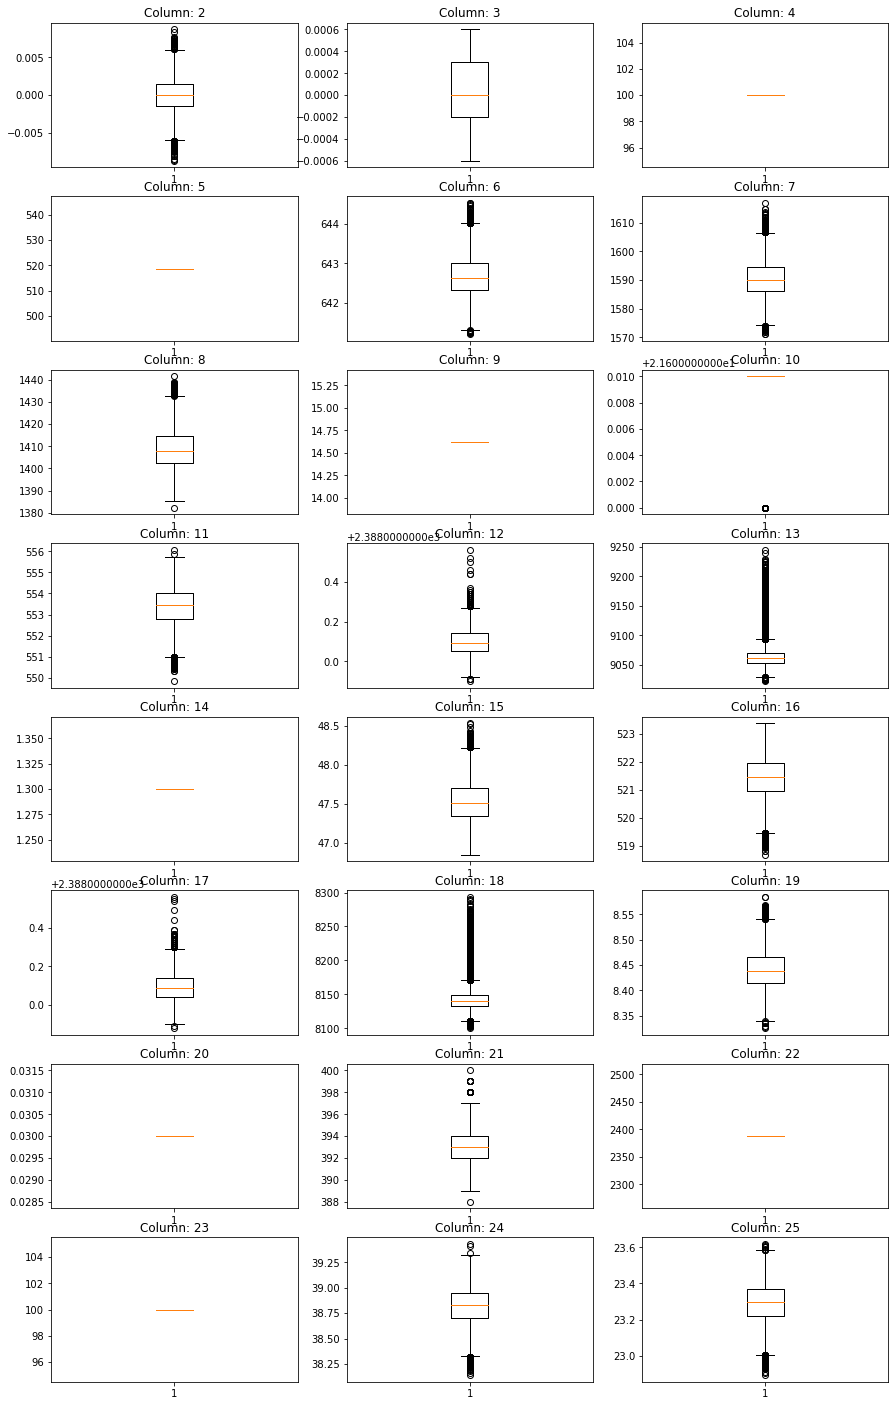

In [36]:
'''
We use box-plot to have a statistic in each column of the dataset ()
'''
fig, axes =  plt.subplots(8,3,figsize=(15,25))

for i in np.arange(2, 26):        # column 5 in python means actual 6th column
    row_position = int(np.floor(i-2)/3)
    col_position = int((i-2)%3)
    temp = train_data.iloc[:, i]
    axes[row_position,col_position].boxplot(temp)
    axes[row_position,col_position].set_title("Column: "+ str(i))
plt.show()

From the above plot we see that columns 4, 5, 9, 10, 14, 20, 22, 23 contain constant values (or only a very few different values).

Constant values don't help us much while training an algorithm (it might even do more harm than good to include constant features). Sometimes we also have to normalize data (subtract mean and divide by standard deviation). If a column contains a constant value, its standard deviation is zero. So normalization of that column is not possible as it requires division by zero. For these reasons, we will drop the columns containing constant values.

### Some decisions on data pre-processing

Before actually training an algorithm, we often need to ask ourself the following (non-exhauted) list of questions:

- Should data be scaled?
- If data are scaled, should a single scaling be applied to all engines or individual scaling be applied for every engine?
- Should we split the training data into training set and validation set
- Given an algorithm, how should we test its performance? Which samples from the test set to be used?

**In the context of RUL-prediction, there is another important question:**
Naively, we can feed each row of the data (i.e., an instance of state of an engine) as a data point into the algorithm; however, doing so will ignore the fact that we are dealing with temporal data. Therefore, we pose the question:

- Shall we use window of data to feed into the traning algorithm? If yes, which window lengths and how do they overlap?

![window preprocessing](data_windowing_prognosis.png)
